# Dependencies

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('drive/MyDrive/modules')
!nvidia-smi

Fri Feb 18 14:54:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# from here
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import keras
from keras.layers import Dense, Input, GlobalAveragePooling1D, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Activation, AveragePooling2D, Flatten
# from tensorflow.keras.applications.vgg16 import VGG16
import argparse
from imutils import paths
from sklearn.metrics import recall_score, precision_score, f1_score, \
    accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay

from aspectawarepreprocessor import AspectAwarePreprocessor
from imagetoarraypreprocessor import ImageToArrayPreprocessor
from simpledatasetloader import SimpleDatasetLoader

from tensorflow.keras.optimizers import Adam,SGD
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model
from keras import backend as K, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from keras import layers as L
import tensorflow as tf
# from keract import get_activations, display_activations
from matplotlib import pyplot

# Image Process

In [5]:
parent = "/content/drive/MyDrive/Data/train_images/train_images"

labels_train = pd.read_csv("/content/drive/MyDrive/Data/labels_train.csv")

imagePaths = []
for path in labels_train['file_name']:
  wholePath = os.path.join(parent,path)
  imagePaths.append(wholePath)



sp = AspectAwarePreprocessor(224, 224)
iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
X = sdl.load(imagePaths, verbose=500)

Y_train = [l for l in labels_train['class_id']]

X_train, X_val, Y_train, Y_val = train_test_split(X,Y_train,test_size=0.2,shuffle=True)

X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255

Y_train = tf.keras.utils.to_categorical(Y_train,num_classes=3)
Y_val = tf.keras.utils.to_categorical(Y_val,num_classes=3)

print(f"[INFO] Found {X_train.shape[0]} images for training with shape:{X_train.shape[1:]}.")
print(f"[INFO] Found {X_val.shape[0]} images for validation with shape:{X_val.shape[1:]}.")

[INFO] processed 500/4672
[INFO] processed 1000/4672
[INFO] processed 1500/4672
[INFO] processed 2000/4672
[INFO] processed 2500/4672
[INFO] processed 3000/4672
[INFO] processed 3500/4672
[INFO] processed 4000/4672
[INFO] processed 4500/4672
[INFO] Found 3737 images for training with shape:(224, 224, 3).
[INFO] Found 935 images for validation with shape:(224, 224, 3).


# Augment Data

In [6]:
datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 20,
    width_shift_range=0.5,
    height_shift_range=0.2
)
datagen.fit(X_train)

# Callbacks

In [7]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=0.0000001, verbose=1)


model_weights = 'alexlike_v5-e{epoch:04d}-loss{loss:.3f}-acc{acc:.3f}-valloss{val_loss:.3f}-valacc{val_acc:.3f}.h5'
checkpoint_filepath = os.path.join("/content/drive/MyDrive/Weights",model_weights)

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True)

calls = [lr_reducer,modelCheckpoint]

# AlexLike CNN

In [8]:
model_path = "/content/drive/MyDrive/Saved_Models/alexlike"
model_version = "_v6.h5"
model_name = os.path.join(model_path,model_version)

if os.path.isfile(model_name):
  print('Loading model..')
  model = tf.keras.models.load_model(model_name)
else:
  x_in = L.Input((224,224,3))

  # 1st Convolution layer with 16 filters
  x = L.Conv2D(16, kernel_size=(11, 11), padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros',activation='relu')(x_in)
  x = L.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

  # 2nd Convolution layer with 96 filters
  x = L.Conv2D(96, kernel_size=(1, 1), padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros',activation='relu')(x)
  x = L.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

  # 3rd Convolution layer with 192 filters
  x = L.Conv2D(192, kernel_size=(5, 5), padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu')(x)
  x = L.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

  # 4th Convolution layer with 192 filters
  x = L.Conv2D(192, kernel_size=(1, 1), padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu')(x)
  x = L.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

  # 5th Convolution layer with 192 filters
  x = L.Conv2D(192, kernel_size=(1, 1), padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu')(x)

  # 6th Convolution layer with 192 filters
  x = L.Conv2D(192, kernel_size=(1, 1), padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu')(x)

  # 7th Convolution layer with 10 filters
  x = L.Conv2D(10, kernel_size=(1, 1), padding='same', kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu')(x)
  x = L.AveragePooling2D(pool_size=(6, 6))(x)

  # Flatten Layer
  x = L.Flatten()(x)

  # 3 Fully Connected Layers 
  x = L.Dense(4096, activation= 'relu')(x)
  x = L.Dropout(0.5)(x)
  x = L.Dense(4096, activation= 'relu')(x)
  x = L.Dropout(0.5)(x)
  x = L.Dense(1000, activation= 'relu')(x)
  x = L.Dropout(0.5)(x)

  # Output Layer
  out = L.Dense(3, kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='softmax')(x)

  model = Model(inputs=x_in,outputs=out)
  model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
        loss="categorical_crossentropy",
        metrics=['acc']
    )

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      5824      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 96)      1632      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 96)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 192)       460992

# Train

In [9]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32), epochs=100, verbose=1, validation_data=(X_val,Y_val),callbacks=calls)
model.save(model_name)
print('Saving Trained Model.')

Epoch 1/100
117/117 [==============================] - 64s 442ms/step - loss: 1.0554 - acc: 0.4811 - val_loss: 0.9896 - val_acc: 0.4984 - lr: 1.0000e-04
Epoch 2/100
117/117 [==============================] - 50s 429ms/step - loss: 0.8965 - acc: 0.5804 - val_loss: 0.7562 - val_acc: 0.6524 - lr: 1.0000e-04
Epoch 3/100
117/117 [==============================] - 50s 426ms/step - loss: 0.8038 - acc: 0.6270 - val_loss: 0.7571 - val_acc: 0.6909 - lr: 1.0000e-04
Epoch 4/100
117/117 [==============================] - 50s 425ms/step - loss: 0.7613 - acc: 0.6516 - val_loss: 0.6833 - val_acc: 0.7102 - lr: 1.0000e-04
Epoch 5/100
117/117 [==============================] - 49s 416ms/step - loss: 0.7396 - acc: 0.6690 - val_loss: 0.6881 - val_acc: 0.7187 - lr: 1.0000e-04
Epoch 6/100
117/117 [==============================] - 49s 417ms/step - loss: 0.7237 - acc: 0.6663 - val_loss: 0.8981 - val_acc: 0.6310 - lr: 1.0000e-04
Epoch 7/100
117/117 [==============================] - 48s 413ms/step - loss: 0.70

# Evaluate and Predict

In [10]:
scores = model.evaluate(X_val,Y_val)
print(f"Validation Loss :{scores[0]}")
print(f"Validation Accuracy :{scores[1]}")

30/30 [==============================] - 2s 57ms/step - loss: 0.5768 - acc: 0.7647
Validation Loss :0.576753556728363
Validation Accuracy :0.7647058963775635


# Plot models

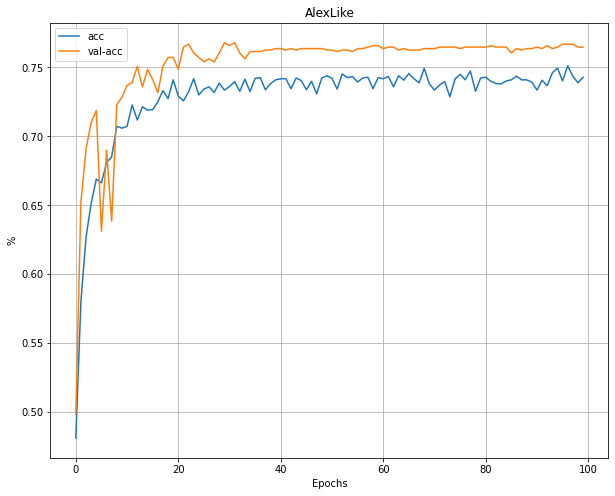

In [11]:
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("AlexLike")
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend(('acc','val-acc'))
plt.grid(b=True)